In [1]:
'''
CSE 163 Final Project
Alex Hayes
Sedona Munguia
Imports and cleans data for analysis
'''

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


def standardize_and_merge(avocado, cities):
    '''
    Takes the cities and avocado datasets as parameters, standardizes the city
    names so the data merges cleanly and keeps all the data for analysis.
    Creates a new dataframe that has the avocado and cities dataframes merged
    by city and turns this new dataframe into a timeseries. Returns the new dataframe.
    '''

    cities.city = cities.city.str.replace(' ', '').str.lower()
    avocado.region = avocado.region.str.lower()
    data = avocado.merge(cities, left_on='region', right_on='city', how='left')
    data.index = pd.to_datetime(data['Date'])

    return data


def clean_data(data):
    '''
    Takes the merged data as a parameter, cleans the data for analysis in both our
    plotting and ML learning modules. Accomplishes this by cleaning up city name
    duplicates (cities that have the same name in multiple places) by population
    and getting rid of regions that do not have a specified lat and long.
    Returns cleaned dataframe.
    '''

    data = data[(data['city'] != 'west') & (data['city'] != 'california') & (data['city'] != 'plains')
            & (data['city'] != 'northeast') & (data['population'] > 100000) & (data['state_name'] != 'Maine')]
    data = data.loc[~((data['state_name'] == 'North Carolina') & (data['city'] == 'jacksonville')),:]
    data = data.loc[~((data['state_name'] == 'Georgia') & (data['city'] == 'columbus')),:]
    data = data.drop(columns=['Unnamed: 0'])

    return data


def zip_lat_long(data):
    '''
    Takes the merged data as a parameter, zips the latitude and
    longitude from the data into single points and creates a new
    column in the dataframe that has the coordinates as its entries.
    Returns this edited dataframe
    '''

    data = data[(data['lng'] < 0) & (data['lng'] > -140)]
    data['coordinates'] = [Point(long, lat) for long, lat in zip(data['lng'], data['lat'])]
    data = gpd.GeoDataFrame(data, geometry='coordinates')

    return data


def main():
    '''
    Executes program.
    '''
    
    avocado = pd.read_csv(r'Data\avocado.csv')
    cities = pd.read_csv(r'Data\uscities.csv')
    data = standardize_and_merge(avocado, cities)
    data = clean_data(data)
    data = zip_lat_long(data)


if __name__ == '__main__':
    main()    

In [2]:
#For testing in Jupyter

avocado = pd.read_csv(r'Data\avocado.csv')
cities = pd.read_csv(r'Data\uscities.csv')
data = standardize_and_merge(avocado, cities)
data = clean_data(data)
data = zip_lat_long(data)

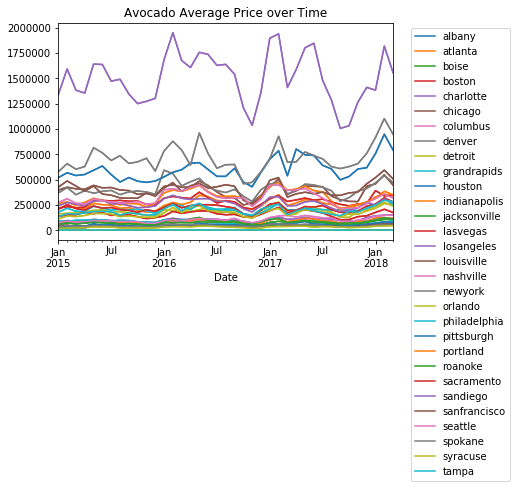

In [6]:
'''
CSE 163 Final Project
Alex Hayes
Sedona Munguia
Creates data visualizations
'''

import pandas as pd
import geopandas as gpd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt
#from Clean_Data import *


def resample_data(data):
    """
    Takes in data and returns the data grouped by city
    resampled by month and averaged
    """

    data.index = pd.to_datetime(data['Date'])
    df = data.groupby('city')
    cities = list(df.groups.keys())
    df = df.resample('M').mean()
    df['Vol Per Capita'] = df['Total Volume'] / df['population']

    return (df, cities)


def plotting(df, cities, col, scale):
    """
    Takes in dataframe, cities, column name, and scale to plot and
    creates a bubble map that changes with time, with bubble
    size correlating to the column given divided by scale
    """

    length = len(df.loc[cities[0]])
    dates = pd.period_range('2015-01-31', periods=length, freq='M')
    df['text'] = col+ ': ' + (df[col]).astype(str)
    limits = [(i,i+1) for i in range(length)]

    fig = go.Figure()

    for i in range(len(limits)):
        lim = limits[i]
        df_sub = df.loc[cities[0]][lim[0]:lim[1]]

        for city in cities[1:]:
            df_sub = df_sub.append(df.loc[city][lim[0]:lim[1]])

        fig.add_trace(go.Scattergeo(
            locationmode = 'USA-states',
            lon = df_sub['lng'],
            lat = df_sub['lat'],
            text = df_sub['text'],
            marker = dict(
                size = df_sub[col]/scale,
                color = "lightseagreen",
                line_color='rgb(40,40,40)',
                line_width=0.5,
                sizemode = 'area'),
            name = '{0} - {1}'.format(lim[0],lim[1])))

    steps = []
    for i in range(len(fig.data)):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},
                  {"title": "Date: " + str(dates[i])}], )
        step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(active=10, currentvalue={"prefix": "Date: "}, pad={"t": 50}, steps=steps)]

    fig.update_layout(
            sliders=sliders,
            title_text = 'Avocado ' + col + '<br>(Click legend to toggle traces)',
            geo = dict(scope = 'usa', landcolor = 'rgb(217, 217, 217)',))

    fig.show()


def vol_map(data):
    """
    Takes in the tuple of dataframe and list of cities from
    the resample data and plots a map using Volume per Capita
    """

    plotting(data[0], data[1], 'Vol Per Capita', 0.0002)
    
    
def price_map(data):
    """
    Takes in the tuple of dataframe and list of cities from
    the resample data and plots a map using Average Price
    """
    
    plotting(data[0], data[1], 'AveragePrice', 0.003)
    
    
def vol_plot(data):
    """
    Takes in tuple from resample data and creates a plot of
    total volume over time
    """

    df = data[0]
    for i in data[1]:
        x = df['Total Volume'].loc[i]
        x.plot()

    plt.title('Avocado Volume over Time')
    plt.legend(data[1], loc='upper center', bbox_to_anchor=(1.2, 1))
    plt.savefig('vol_plot.png')


def vpc_plot(data):
    """
    Takes in tuple from resample data and creates a plot of
    volume per capita over time
    """

    df = data[0]
    for i in data[1]:
        x = df['Total Volume'].loc[i]
        x.plot()

    plt.title('Avocado Volume per Capita over Time')
    plt.legend(data[1], loc='upper center', bbox_to_anchor=(1.2, 1))
    plt.savefig('vpc_plot.png')


def price_plot(data):
    """
    Takes in tuple from resample data and creates a plot of
    average price over time
    """

    df = data[0]
    for i in data[1]:
        x = df['AveragePrice'].loc[i]
        x.plot()

    plt.title('Avocado Average Price over Time')
    plt.legend(data[1], loc='upper center', bbox_to_anchor=(1.2, 1))
    plt.savefig('price_plot.png')

def main():
    '''
    Executes program.
    '''
    result = resample_data(data)
    #vol_plot(result)
    #vpc_plot(result)
    #price_plot(result)
    vol_map(result)
    price_map(result)


if __name__ == '__main__':
    main()    

In [4]:
'''
CSE 163 Final Project
Alex Hayes
Sedona Munguia
Creates a ML model, creates visualizations
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import graphviz
from sklearn.tree import export_graphviz
#from Clean_Data import *


def user_input_data(data):
    '''
    Takes dataframe as a parameter. Prints a list of cities for
    that the user can choose from to create a ML model. Returns the
    city that is inputted.
    '''

    print(list(data.city.unique()))
    print('Enter desired city from list above')
    city = input()
    
    print('Predict price or volume?')
    print('Enter price/volume')
    model_type = input()

    return city, model_type


def setup_data(city, data):
    '''
    Takes in a user inputted city and the cleaned dataframe as
    parameters. Removes unnecessary columns for machine learning and
    groups by the city that is entered. Returns a dataframe that is
    ready for a ML model to be created on.
    '''
    
    data_ml = data[['AveragePrice', 'Total Volume', 'city', 'Total Bags', 'Small Bags', 'population',
                    'density', '4046', '4225', '4770', 'Large Bags', 'XLarge Bags']]
    data_ml = data_ml[data_ml['city'] == city][0:169]
    data_ml = data_ml.drop(columns=['city'])

    return data_ml


def create_labels_features(data_ml, model_type):
    '''
    Takes in the ml dataframe and the model type as parameters.
    Creates the features and labels for the model, splits the data
    into training and testing data. Returns training and testing sets
    for both features and labels.
    '''

    if model_type == 'price':
        features = data_ml.loc[:, data_ml.columns != 'AveragePrice']
        labels = data_ml['AveragePrice']

    else:
        features = data_ml.loc[:, data_ml.columns != 'Total Volume']
        labels = data_ml['Total Volume']

    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, train_size=.30788, shuffle=False)

    return [features_train, features_test, labels_train, labels_test]


def find_max_depth(lf_list):
    '''
    Takes in list of features and labels as parameters, runs through
    200 models to find the max_depth that produces the lowest MSE in
    the ml model. Returns max depth.
    '''
    
    max_depth_lst = []
    for max_depth in range(1, 201):
        model = DecisionTreeRegressor(max_depth=max_depth)
        model.fit(lf_list[0], lf_list[2])

        test_predictions = model.predict(lf_list[1])
        max_depth_lst.append(mean_squared_error(lf_list[3], test_predictions))

    return max_depth_lst.index(min(max_depth_lst)) + 1


def find_min_impurity_decrease(lf_list):
    '''
    Takes in list of features and labels as parameters, runs through
    200 models to find the min impurity decrease that produces the lowest
    MSE in the ml model. Returns min impurity decrease.
    '''
    
    min_impurity_lst = []
    for min_impurity in np.linspace(0, 1, 200):
        model = DecisionTreeRegressor(min_impurity_decrease=min_impurity)
        model.fit(lf_list[0], lf_list[2])

        test_predictions = model.predict(lf_list[1])
        min_impurity_lst.append(mean_squared_error(lf_list[3], test_predictions))

    return min_impurity_lst.index(min(min_impurity_lst))


def find_max_leaf_nodes(lf_list):
    '''
    Takes in list of features and labels as parameters, runs through
    200 models to find the max leaf nodes that produces the lowest MSE in
    the ml model. Returns max leaf nodes.
    '''
    
    max_leaf_lst = []
    for max_leaf_nodes in range(2, 202):
        model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
        model.fit(lf_list[0], lf_list[2])

        test_predictions = model.predict(lf_list[1])
        max_leaf_lst.append(mean_squared_error(lf_list[3], test_predictions))

    return max_leaf_lst.index(min(max_leaf_lst)) + 1

def find_min_samples_leaf(lf_list):
    '''
    Takes in list of features and labels as parameters, runs through
    200 models to find the min leaf sampls that produces the lowest MSE in
    the ml model. Returns min leaf samples.
    '''
    
    min_samples_lst = []
    for min_samples_leaf in range(1, 201):
        model = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf)
        model.fit(lf_list[0], lf_list[2])

        test_predictions = model.predict(lf_list[1])
        min_samples_lst.append(mean_squared_error(lf_list[3], test_predictions))

    return min_samples_lst.index(min(min_samples_lst)) + 1


def create_model(data_ml, max_depth, min_impurity, max_leaf_nodes, min_leaf_samples, lf_list):
    '''
    Takes in the machine learning ready dataframe and the calculated
    hyperparameters as parameters. Creates a model from a decision
    tree regressor. Prints the MSE of the training and testing data sets,
    returns the model, training and testing predictions.
    '''

    model = DecisionTreeRegressor(max_depth=max_depth, min_impurity_decrease=min_impurity,
                                  max_leaf_nodes=max_leaf_nodes, min_samples_leaf=min_leaf_samples)
    model.fit(lf_list[0], lf_list[2])

    train_predictions = model.predict(lf_list[0])
    test_predictions = model.predict(lf_list[1])

    train_err = mean_squared_error(lf_list[2], train_predictions)
    test_err = mean_squared_error(lf_list[3], test_predictions)
    
    print('Training MSE:', train_err)
    print('Testing MSE:', test_err)
    
    return model, train_predictions, test_predictions


def plot_tree(model, lf_list):
    '''
    Takes the model, features, and labels as parameters, creates
    a decision tree based on these, plots the Graphviz source data
    as a pdf, saves the pdf in the plots folder.
    '''
    dot_data = export_graphviz(model, out_file=None, 
            feature_names=lf_list[0].columns,  
            class_names=lf_list[2].unique(),
            impurity=False,
            filled=True, rounded=True,  
            special_characters=True) 
    source_data = graphviz.Source(dot_data)

    source_data.render('plots/tree_model.gv', view=True)


def plot_feature_importances(model, model_type):
    '''
    Takes in the ML model and model type as parameters, plots a bar
    chart of the feature importances used in the ml model. Saves this
    fig in the plots folder as feature_importances.pdf.
    '''

    a = model.feature_importances_
    x = np.arange(10)
    plt.bar(x, a)
    plt.title('feature importance')

    if model_type == 'price':
        plt.xticks(x, ('Total Volume', 'Total Bags', 'Small Bags',
                       'population', 'density', '4046', '4225', '4770',
                       'Large Bags', 'XLarge Bags'), rotation='vertical')


    else:
        plt.xticks(x, ('Average Price', 'Total Bags', 'Small Bags',
                       'population', 'density', '4046', '4225', '4770',
                       'Large Bags', 'XLarge Bags'), rotation='vertical')

    plt.savefig('plots/feature_importances.pdf')


def plot_accuracy(model, model_type, data_ml, city, train_predictions, test_predictions):
    '''
    Takes in the ml model, model type, and the ml dataframe
    as parameters, creates a plot visualizing the accuracy of
    the ml model for the city inputted. Saves this plot in the
    plots folder as plot_accuracy.pdf.
    '''
    
    if model_type == 'price':
        data_ml['Avg Price Prediction'] = np.append(train_predictions, test_predictions)
        predict = data_ml['Avg Price Prediction']
        actual = data_ml['AveragePrice']
    
    else:
        data_ml['Total Volume Prediction'] = np.append(train_predictions, test_predictions)
        predict = data_ml['Total Volume Prediction']
        actual = data_ml['Total Volume']
    
    fig, ax = plt.subplots()
    actual.plot(ax=ax, label='Actual')
    predict.plot(ax=ax, label='Predicted')
    ax.legend()
    ax.set_title(city + ' ' + model_type)
    
    plt.savefig('plots/plot_accuracy.pdf')


def main():
    '''
    Executes program.
    '''

    city, model_type = user_input_data(data)
    data_ml = setup_data(city, data)
    lf_list = create_labels_features(data_ml, model_type)
    max_depth = find_max_depth(lf_list)
    min_impurity = find_min_impurity_decrease(lf_list)
    max_leaf_nodes = find_max_leaf_nodes(lf_list)
    min_leaf_samples = find_min_samples_leaf(lf_list)
    model, train_predictions, test_predictions = create_model(data_ml, max_depth, min_impurity, max_leaf_nodes, min_leaf_samples, lf_list)
    
    plot_tree(model, lf_list)
    plot_feature_importances(model, model_type)
    plot_accuracy(model, model_type, data_ml, city, train_predictions, test_predictions)


if __name__ == '__main__':
    main()

ModuleNotFoundError: No module named 'graphviz'